In [1]:
import torch
import torch.nn as nn
from pau import PAU

import numpy as np

import json
from pathlib import Path

import matplotlib.pyplot as plt

import quad
from utils import init_sequential

torch.set_grad_enabled(False)

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred'
FIGURES_BASIS = FIGURES / 'basis'
FIGURES_ERROR = FIGURES / 'error'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

ROOT = Path('model')
ARCH = Path('arch')

savefig = True

plt.rc('font', size=16)
plt.rc('lines', linewidth=4)

name = 'S1_100'
epoch = 10_000

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

PATH = ROOT / name

MODEL_PREFIX = r'$S^1_{\theta}$'
FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}_slide'

In [2]:
A = init_sequential(params['layers-apprx'])
T = init_sequential(params['layers-trunk'])

In [3]:
data = torch.load(PATH / f'{epoch}.model')
A.load_state_dict(data['A'][0])
T.load_state_dict(data['T'][0])

<All keys matched successfully>

In [4]:
match params['quad_name']:
    case 'gaussian':
        int_p, int_w = quad.gaussian_quadrature(0, 1, params['quad_size'])
    case 'trapezoidal':
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad_size'])
    case _:
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad_size'])

In [5]:
def model(x, p):
    ''' x.shape = (batch_size, enc_dim),  p.shape = (num)
    -> (batch_size, latdim)
    '''
    # A -> (batch_size, lat_dim),  T -> (num, lat_dim)
    a = A(x)
    b = T(p.unsqueeze(dim=1))
    return a@b.T

In [6]:
x_ds, y_ds = torch.load(PATH / 'valid.ds')
ds_file = f'dataset/{params["ds"]}/valid/'
ds_size = len(x_ds)
ds_step = ds_size // 5

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


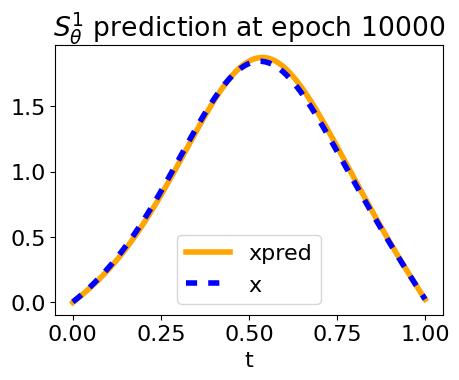

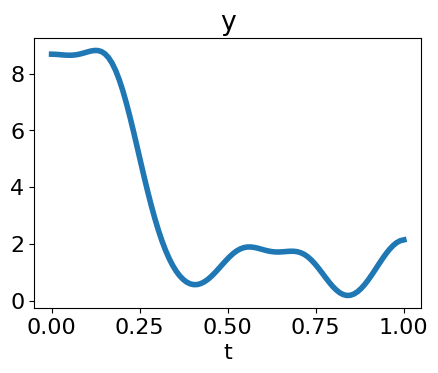

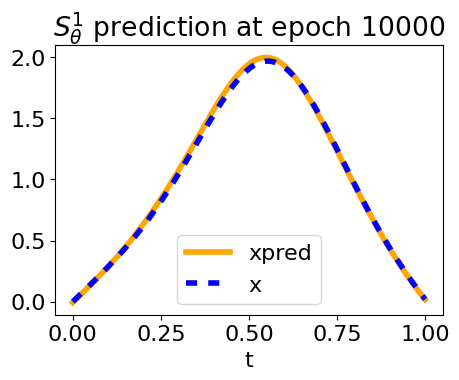

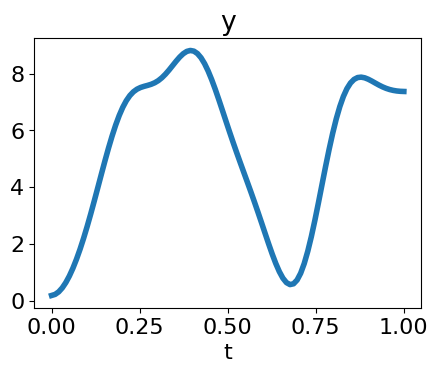

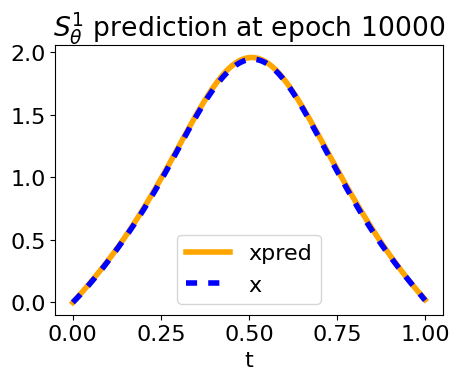

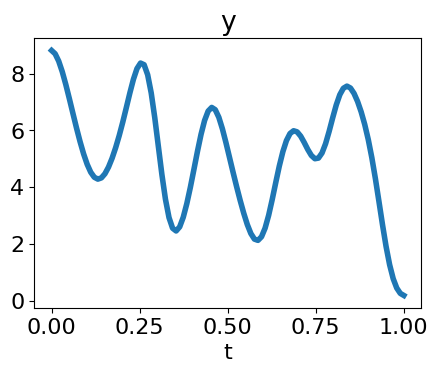

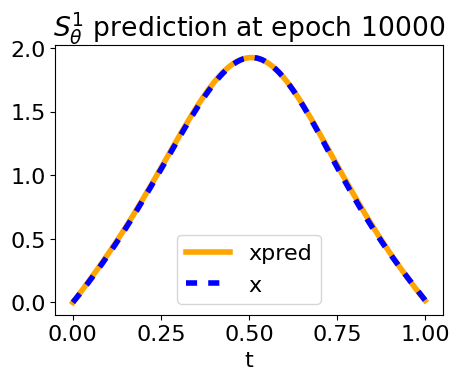

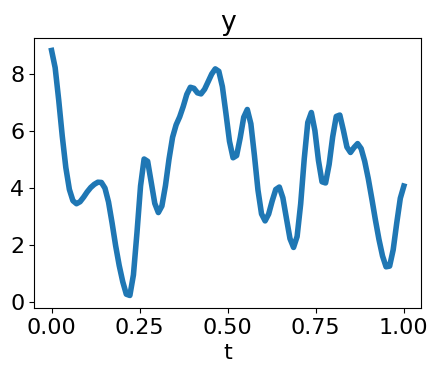

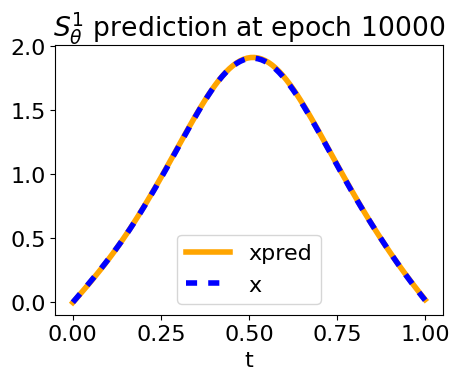

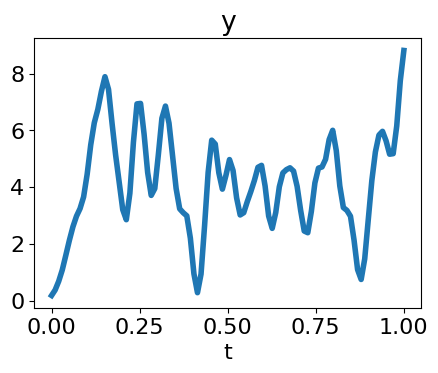

In [7]:
for i, j in enumerate(range(0, ds_size, ds_step)):
    xpred = model(x_ds[j], int_p).squeeze()

    plt.figure(figsize=(5, 3.5))
    plt.tight_layout()

    plt.plot(int_p, xpred, c='orange', label='xpred')
    plt.plot(int_p, y_ds[j], 'b--', dashes=[2], label='x')
    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')
    
    plt.title(MODEL_PREFIX + f' prediction at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_ds[j])
    plt.xlabel('t')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_Fig{i}.png', bbox_inches='tight')
    plt.title('y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

# Basis Extraction

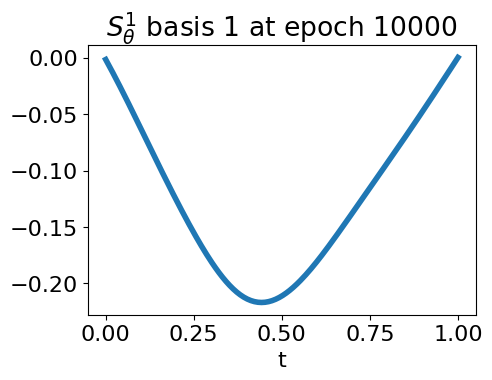

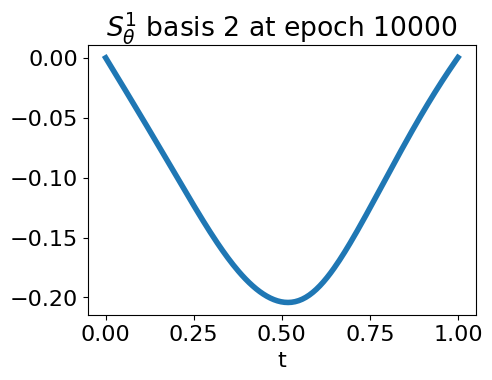

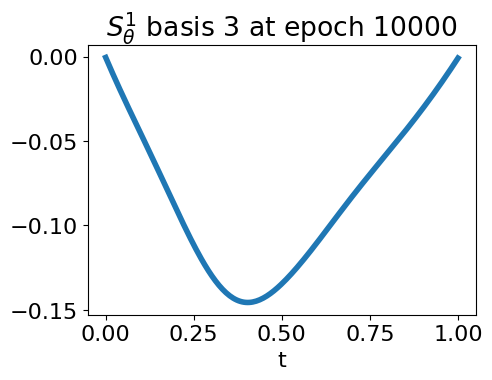

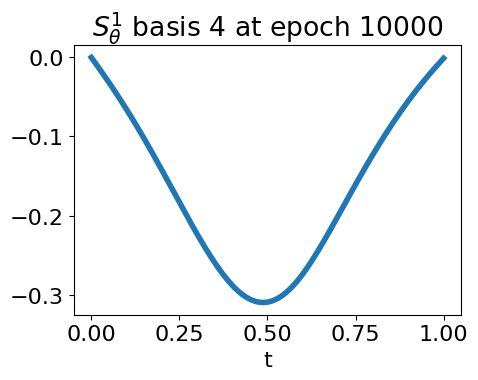

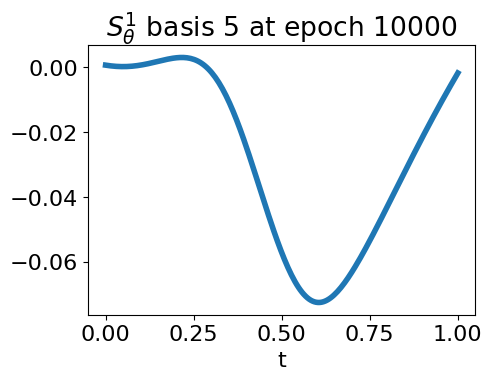

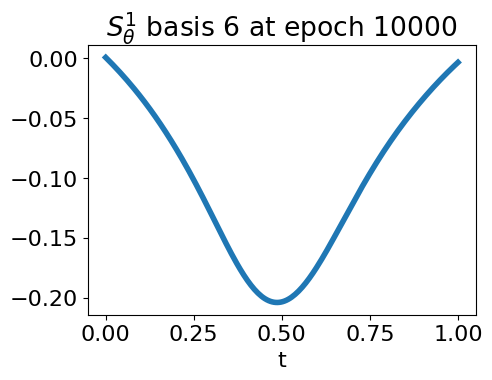

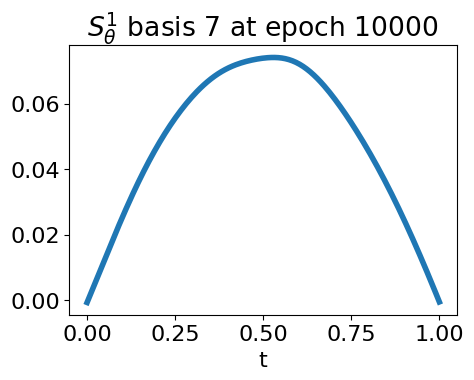

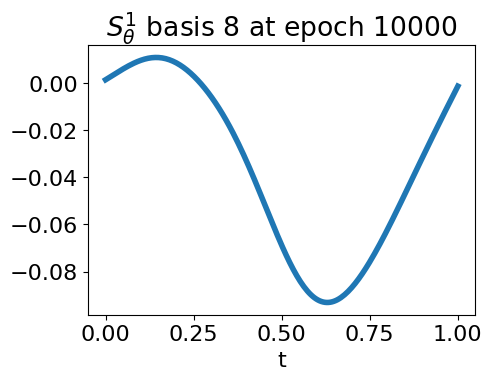

In [8]:
N = 200
t = torch.linspace(0, 1, N)

fun = T(t.unsqueeze(dim=1)).T
for i, f in enumerate(fun):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, f)
    plt.xlabel('t')
    plt.title(MODEL_PREFIX + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Trunk{i}_with_title.png', bbox_inches='tight')
    plt.show()

In [9]:
int_p, int_w = quad.trapezoidal_rule(0, 1, N)

V = fun
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

_, int_w = quad.trapezoidal_rule(0, 1, N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])

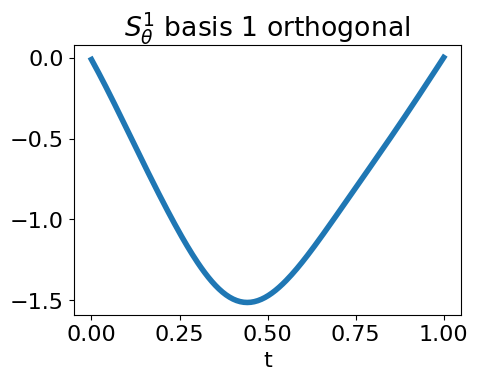

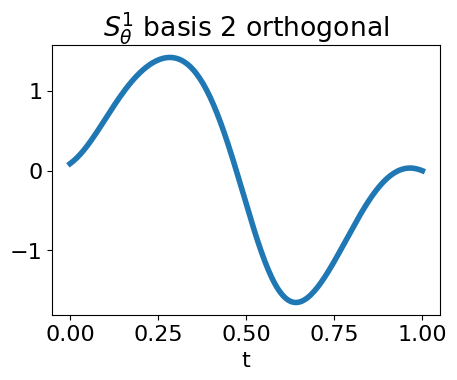

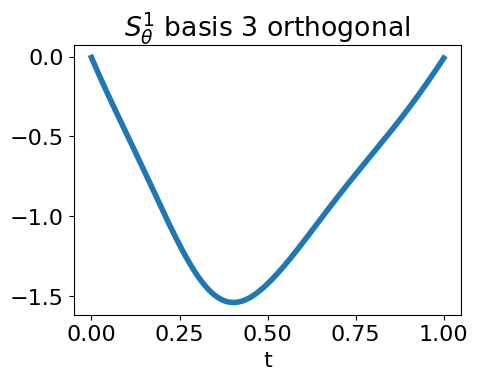

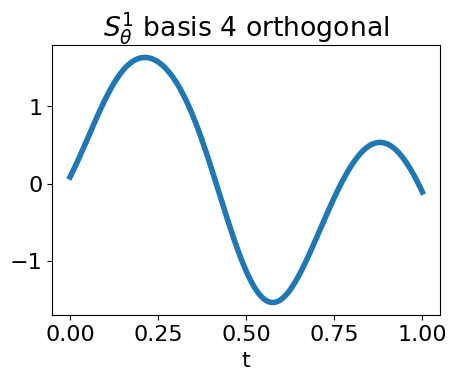

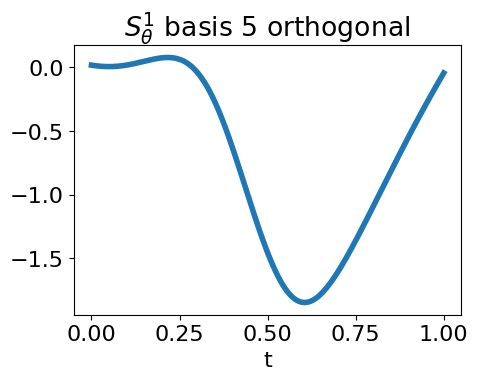

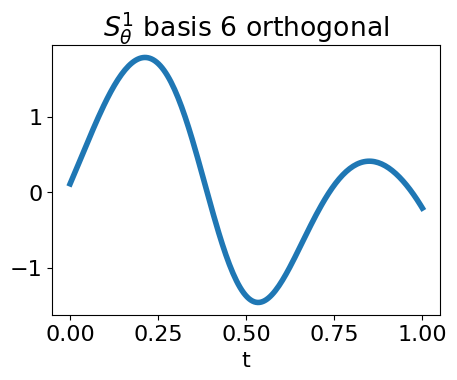

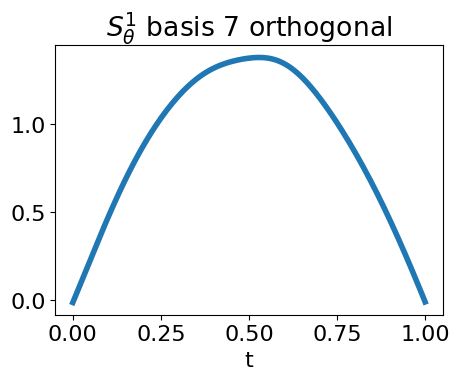

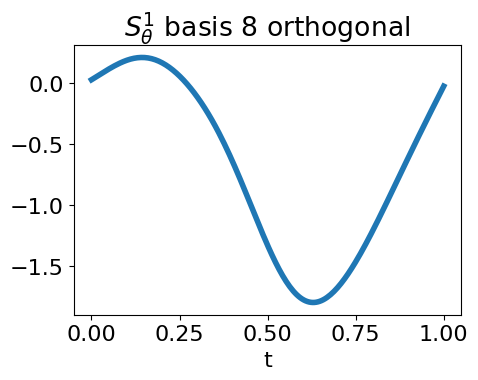

In [10]:
ofun = np.array(Q)

for i, of in enumerate(ofun):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, of)
    plt.xlabel('t')
    plt.title(MODEL_PREFIX + ' basis {} orthogonal'.format(i+1))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_oTrunk{i}_with_title.png', bbox_inches='tight')
    plt.show()

 Error

In [11]:
def read_error_log(logfile, rf, maxepoch=float('infinity')):
    error = []
    with open(logfile, 'r') as f:
        for line in f:
            ep, err = line.strip().split(',')
            ep = int(ep)
            err = float(err)

            if ep > maxepoch:
                break
            
            if ep % rf == 0:
                error.append(err)
    return error

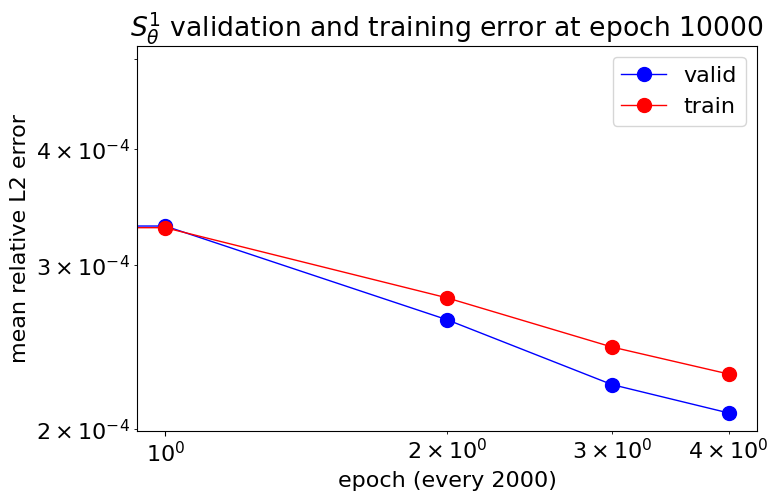

<Figure size 800x500 with 0 Axes>

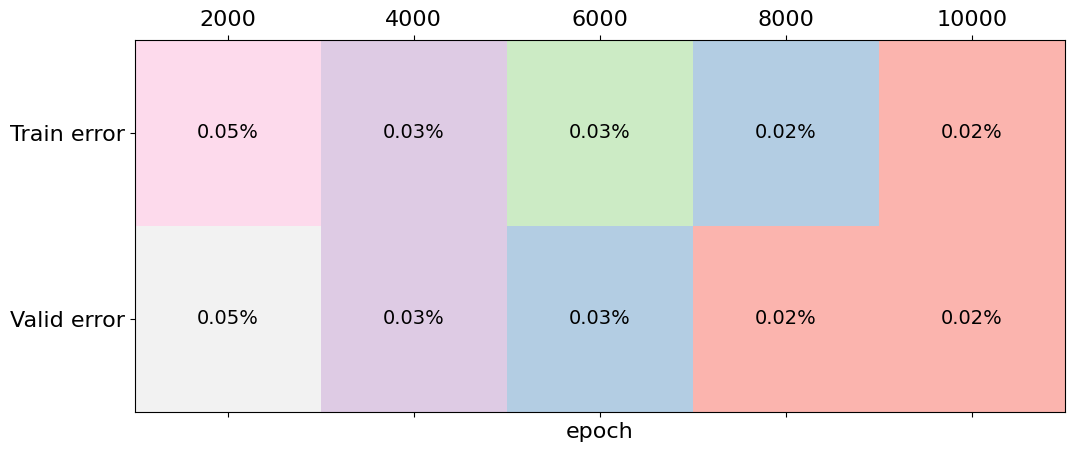

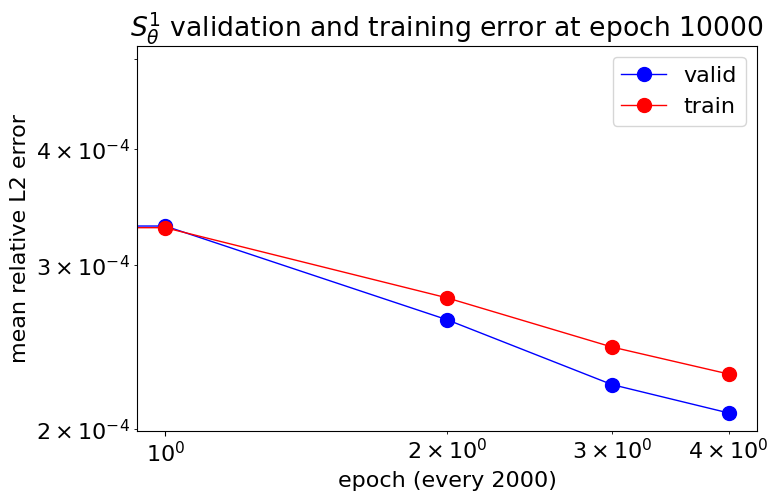

<Figure size 800x500 with 0 Axes>

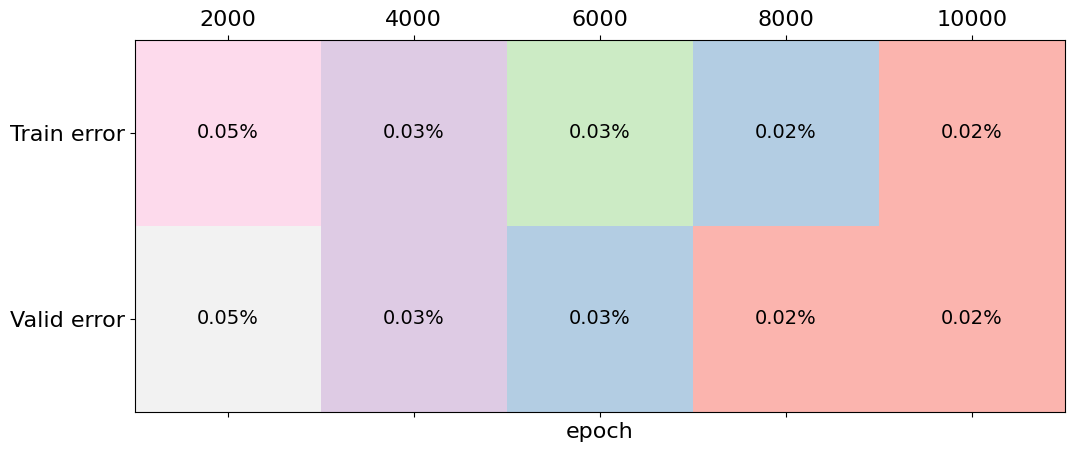

In [12]:
for rf_ in [5, 10]:
    rf = epoch // 5
    timeline = [i for i in range(rf, epoch+rf, rf)]
    
    valid_error = read_error_log(PATH / 'valid.error', rf, maxepoch=epoch)
    train_error = read_error_log(PATH / 'train.error', rf, maxepoch=epoch)

    ##  PLOT
    plt.figure(figsize=(8, 5))
    plt.loglog(valid_error, '-ob', label='valid', markersize=10, linewidth=1)
    plt.loglog(train_error, '-or', label='train', markersize=10, linewidth=1)
    plt.xlabel(f'epoch (every {rf})')
    plt.ylabel('mean relative L2 error')
    plt.title(MODEL_PREFIX + f' validation and training error at epoch {epoch}')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_rf{rf_}.png', bbox_inches='tight')
    plt.show()

    ##  TABLE
    data = np.array(list(zip(train_error, valid_error))).T

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    plt.rc('font', size=16)
    plt.matshow(100 * data, cmap='Pastel1')
    plt.xlabel('epoch')
    plt.xticks(np.array(range(len(timeline))), timeline)
    plt.yticks(list(range(2)), ['Train error', 'Valid error'])
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}%'.format(100 * z), ha='center', va='center', fontsize=14)
    
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}.png', bbox_inches='tight')

    plt.show()